# GA 1.3: Modelling Road Deformation using Non-Linear Least-Squares

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.3. Due: Friday, September 20, 2024.*

In [5]:
import numpy as np
import scipy as sc
from scipy import interpolate

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy.stats.distributions import chi2
from scipy.stats import norm

np.set_printoptions(precision=3)

## Task 1: Preparing the data

Within this assignment you will work with two types of data: InSAR data and GNSS data. The cell below will load the data and visualize the observed displacements time. In this task we use the package `pandas`, which is really useful for handling time series. We will learn how to use it later in the quarter; for now, you only need to recognize that it imports the data as a `dataframe` object, which we then convert into a numpy array using the code below.

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>Cnvert all observations to millimeters.</p></div>

In [6]:
gnss = pd.read_csv('./data/gnss_observations.csv')
times_gnss = pd.to_datetime(gnss['times'])
gnss_obs = (gnss['observations[m]']).to_numpy()*1000

insar = pd.read_csv('./data/insar_observations.csv')
times_insar = pd.to_datetime(insar['times'])
insar_obs = (insar['observations[m]']).to_numpy()*1000

gw = pd.read_csv('./data/groundwater_levels.csv')
times_gw = pd.to_datetime(gw['times'])
gw_obs = (gw['observations[mm]']).to_numpy()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   
    
Once you have used the cell above to import the data, investigate the data sets using the code cell below. Then provide some relevant summary information in the Markdown cell. Hint: use some of the techniques we covered in the Programming Assignments.
    
</p>
</div>

<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>The code below gives some examples of the quantitative and qualitative ways you could have looked at the data. It is more than you were expected to do; the important thing is that you showed the ability to learn something about the data and describe aspects that are relevant to our problem. We use a dictionary to easily access the different data series using their names, which are entered as the dictionary keys (also not expected of you, but it's hopefully fun to learn useful tricks).</div>

In [7]:
data_list = ['gnss_obs', 'insar_obs', 'gw_obs']
data_dict = {data_list[0]: gnss_obs,
             data_list[1]: insar_obs,
             data_list[2]: gw_obs}
def print_summary(data):
    '''Summarize an array with simple print statements.'''
    print('Minimum =     ', data.min())
    print('Maximum =     ', data.max())
    print('Mean =        ', data.mean())
    print('Std dev =     ', data.std())
    print('Shape =       ', data.shape)
    print('First value = ', data[0])
    print('Last value =  ', data[-1])
    print('\n')
          
for item in data_list:
    print('Summary for array: ', item)
    print('------------------------------------------------')
    print_summary(data_dict[item])

Summary for array:  gnss_obs
------------------------------------------------
Minimum =      -77.85967600765021
Maximum =      29.432302555465
Mean =         -26.998775875445148
Std dev =      16.2218064476615
Shape =        (730,)
First value =  -13.980633493923001
Last value =   -38.6733705713608


Summary for array:  insar_obs
------------------------------------------------
Minimum =      -37.339155096180406
Maximum =      -3.7915269917409
Mean =         -25.459757789872686
Std dev =      6.8998022892131585
Shape =        (61,)
First value =  -3.7915269917409
Last value =   -30.2754656176263


Summary for array:  gw_obs
------------------------------------------------
Minimum =      -166.784
Maximum =      -102.044
Mean =         -127.70472
Std dev =      16.822297827633417
Shape =        (25,)
First value =  -109.698
Last value =   -117.268




In [8]:
print('Times are type: ', type(times_insar))

Times are type:  <class 'pandas.core.series.Series'>


<Figure size 1500x400 with 0 Axes>

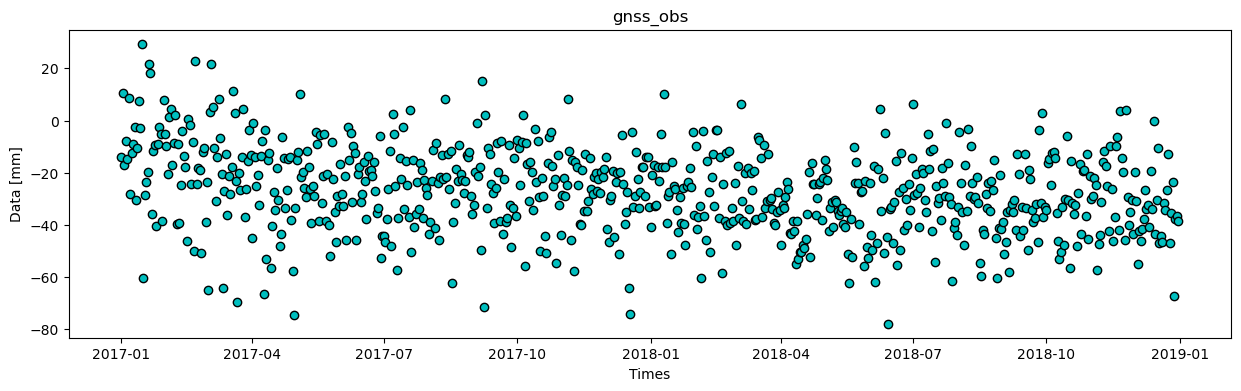

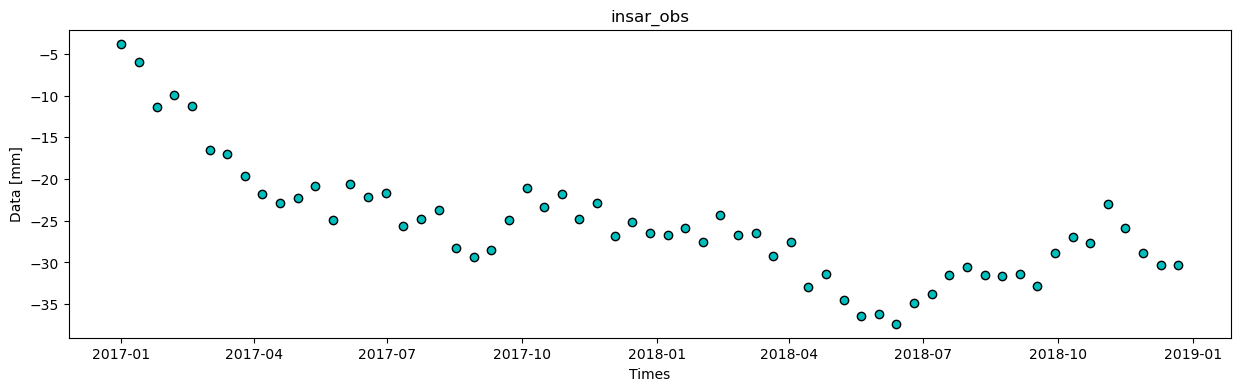

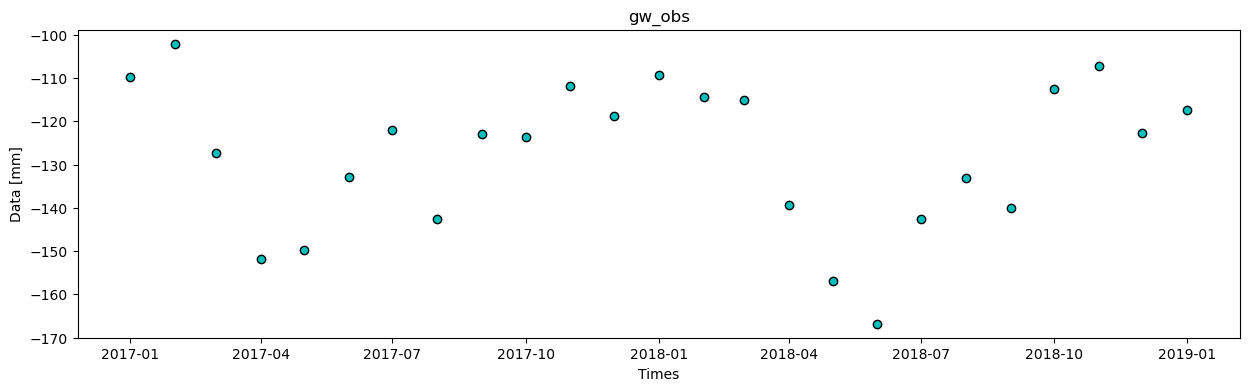

In [9]:
times_dict = {data_list[0]: times_gnss,
              data_list[1]: times_insar,
              data_list[2]: times_gw}
def plot_data(times, data, label):
    plt.figure(figsize=(15,4))
    plt.plot(times, data, 'co', mec='black')
    plt.title(label)
    plt.xlabel('Times')
    plt.ylabel('Data [mm]')
    plt.show()

plt.figure(figsize=(15,4))
for i in range(3):
    plot_data(times_dict[data_list[i]],
              data_dict[data_list[i]],
              data_list[i])

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
There are a lot more GNSS data points than InSAR or groundwater. The GNSS observations also have more noise, and what seem to be outliers. In this case the mean and standard deviation do not mean much, because there is clearly a trend with time. We can at least confirm that the time periods of measurements overlap, although the intervals between measurements is certainly not uniform (note that you don't need to do anything with the times, since they are pandas time series and we have not covered them yet).
</p>
</div>

You may have noticed that the groundwater data is available for different times than the GNSS and InSAR data. You will therefore have to *interpolate* the data to the same times for a further analysis. You can use the SciPy function ```interpolate.interp1d``` (read its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)).

The cells below do the following:
1. Define a function to convert the time unit
2. Convert the time stamps for all data
3. Use `interp1d` to interpolate the groundwater measurements at the time of the satellite measurements

In [10]:
def to_days_years(times):
    '''Convert the observation times to days and years.'''
    
    times_datetime = pd.to_datetime(times)
    time_diff = (times_datetime - times_datetime[0])
    days_diff = (time_diff / np.timedelta64(1,'D')).astype(int)
    
    days = days_diff.to_numpy()
    years = days/365
    
    return days, years

In [11]:
days_gnss,  years_gnss  = to_days_years(times_gnss)
days_insar, years_insar = to_days_years(times_insar)
days_gw,    years_gw    = to_days_years(times_gw)

interp = interpolate.interp1d(days_gw, gw_obs)

GW_at_GNSS_times = interp(days_gnss)
GW_at_InSAR_times = interp(days_insar)

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   
    
Answer/complete the code and Markdown cells below:
<ol>
    <li>What is <code>interp</code>? (what kind of object is it, and how does it work?)</li>
    <li>How did the groundwater observation array change? Be quantitative. </li>
</ol>

2024: instead of printing as below, we can ask them to plot the GW original, and at GNSS and InSAR times and let them explain in report why they had to interpolate, and how interpolation works.
    
</p>
</div>

In [12]:
print('array size of GW_at_GNSS_times', len(GW_at_GNSS_times))
print('array size of GW_at_InSAR_times', len(GW_at_InSAR_times))
print('array size of GW before interpolation', len(gw_obs))

print(times_gw[0:2])
print(gw_obs[0:2])
print(times_gnss[0:2])
print(GW_at_GNSS_times[0:2])

array size of GW_at_GNSS_times 730
array size of GW_at_InSAR_times 61
array size of GW before interpolation 25
0   2017-01-01
1   2017-02-01
Name: times, dtype: datetime64[ns]
[-109.698 -102.044]
0   2017-01-01
1   2017-01-02
Name: times, dtype: datetime64[ns]
[-109.698 -109.451]


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
<ol>
    <li><code>interp</code> is a function that will return a value (gw level) for the input(s) (date(s)). The interpolated value is found by linearly interpolating between the two nearest times in the gw observations.</li>
    <li>The observation arrays of <code>GW_at_GNSS_times</code> and <code>GW_at_INSAR_times</code> changed in size to match the size of the GNSS and InSAR observations, respectively.</li>
</ol>  
</p>
</div>

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3:</b>   
    
Create a single plot to compare observed displacement for the GNSS and InSAR data sets.
    
</p>
</div>

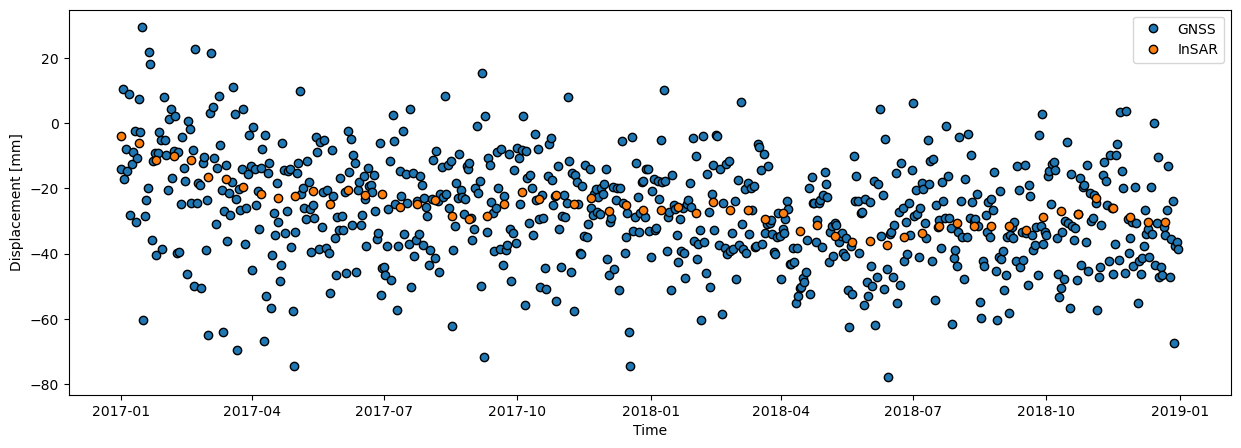

In [13]:
plt.figure(figsize=(15,5))
plt.plot(times_gnss, gnss_obs, 'o', mec='black', label = 'GNSS')
plt.plot(times_insar, insar_obs, 'o', mec='black', label = 'InSAR')
plt.legend()
plt.ylabel('Displacement [mm]')
plt.xlabel('Time')
plt.show()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.4:</b>   
What is your interpretation of the data? What kind of deformation do you see? And what are the differences between both datasets? Be quantitative.
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
The points obviously show subsidence, the displacement shows a similar pattern for both datasets. The GNSS data is much noisier than InSAR (range is around 60 mm versus only a few mm), but has a higher sampling rate. Also there seem to be more outliers in the GNSS data compared to InSAR, especially at the start of the observation period. InSAR has only observations every 6 days but is less noisy. 
</p>
</div>

## Task 2: Set-up linear functional model

We want to investigate how we could model the observed displacements of the road. Because the road is built in the Green Heart we expect that the observed displacements are related to the groundwater level. Furthermore, we assume that the displacements can be modeled using a constant velocity. The model is defined as 
$$
d = d_0 + vt + k \ \textrm{GW},
$$
where $d$ is the displacement, $t$ is time and $\textrm{GW}$ is the groundwater level (that we assume to be deterministic). 

Therefore, the model has 3 unknowns:
1. $d_0$, as the initial displacement at $t_0$;
2. $v$, as the displacement velocity;
3. $k$, as the 'groundwater factor', which can be seen as the response of the soil to changes in the groundwater level.


As a group you will construct the **functional model** that is defined as 
$$
\mathbb{E}(Y) = \mathrm{A x}.
$$



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1:</b>   
    
Construct the design matrix $A$ and the observation vector $Y$ (for both InSAR and GNSS observations), then show the first 5 observations.
</p>
</div>

In [14]:
# Contruct A and Y for InSAR: A_insar, y_insar
# YOUR_CODE_HERE

A_insar = np.ones((len(times_insar), 3))
A_insar[:,1] = days_insar
A_insar[:,2] = GW_at_InSAR_times

print ('The first 5 rows of the A matrix (InSAR) are:')
print (A_insar[0:5, :])

y_insar = insar_obs
print ('The first 5 observations [mm] of y_insar are:')
print (y_insar[0:5])

m_insar = np.shape(A_insar)[0]
n_insar = np.shape(A_insar)[1]
print(f'm = {m_insar} and n = {n_insar}')

The first 5 rows of the A matrix (InSAR) are:
[[   1.       0.    -109.698]
 [   1.      12.    -106.735]
 [   1.      24.    -103.772]
 [   1.      36.    -106.536]
 [   1.      48.    -117.316]]
The first 5 observations [mm] of y_insar are:
[ -3.792  -5.999 -11.403  -9.92  -11.283]
m = 61 and n = 3


In [15]:
# # Contruct A and Y for GNSS: A_gnss, y_gnss
# # YOUR_CODE_HERE

# A_gnss = np.ones((len(times_gnss), 3))
# A_gnss[:,1] = days_gnss
# A_gnss[:,2] = GW_at_GNSS_times

# print ('The first 5 rows of the A matrix (GNSS) are:')
# print (A_gnss[0:5, :])

# y_gnss = gnss_obs
# print ('\nThe first 5 observations [mm] of y_gnss are:')
# print (y_gnss[0:5])

# m_gnss = np.shape(A_gnss)[0]
# n_gnss = np.shape(A_gnss)[1]
# print(f'm = {m_gnss} and n = {n_gnss}')

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 2.2}$
   
Answer the following questions:

- What is the dimension of the observables' vector $Y$?
- What are the unknowns of the functional model?
- What is the redundancy for this model?

</p>
</div>


<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
    
For InSAR:
<ol>
    <li>The number of observations is 61.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 58.</li>
</ol>
    
For GNSS:
<ol>
    <li>The number of observations is 730.</li>
    <li>The number of unknowns is 3.</li>
    <li>The redundancy is 727.</li>
</ol>   
</p>
</div>

## 3. Set-up stochastic model

We will use the Best Linear Unbiased Estimator (BLUE) to solve for the unknown parameters. Therefore we also need a stochastic model, which is defined as
$$
\mathbb{D}(Y) = \Sigma_{Y}.
$$
where $\Sigma_{Y}$ is the covariance matrix of the observables' vector. 




<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
    
Construct the covariance matrix and assume that 

- the observables are independent

- the observables are normally distributed

- the observables' standard deviation is
    
    - $\sigma_\textrm{InSAR} = 2$ mm 
    - $\sigma_\textrm{GNSS} = 15$ mm 
    
</p>
</div>


In [16]:
# Stochastic model for InSAR: Sigma_Y_insar
# YOUR_CODE_HERE

std_insar = 2 #mm

Sigma_Y_insar = np.identity(len(times_insar))*std_insar**2

print ('Sigma_Y (InSAR) is defined as:')
print (Sigma_Y_insar)

Sigma_Y (InSAR) is defined as:
[[4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


In [17]:
# Stochastic model for GNSS: Sigma_Y_gnss
# YOUR_CODE_HERE

std_gnss = 15 #mm (corrected from original value of 5 mm)

Sigma_Y_gnss = np.identity(len(times_gnss))*std_gnss**2

print ('\nSigma_Y (GNSS) is defined as:')
print (Sigma_Y_gnss)


Sigma_Y (GNSS) is defined as:
[[225.   0.   0. ...   0.   0.   0.]
 [  0. 225.   0. ...   0.   0.   0.]
 [  0.   0. 225. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 225.   0.   0.]
 [  0.   0.   0. ...   0. 225.   0.]
 [  0.   0.   0. ...   0.   0. 225.]]


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.2:</b>   
Answer the following questions:
<ol>
    <li>What information is contained in the covariance matrix?</li>
    <li>How do you implement the assumption that all observations are independent?</li>
    <li>What is the dimension of $\Sigma_{Y}$?</li>
    <li>How do you create $\Sigma_{Y}$?</li>
</ol>
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$ 
<ol>
    <li>The covariance matrix contains information on the quality of the observations, where an entry on the diagonal represents the variance of one observation at a particular epoch. If there is an indication that for instance the quality for a particular time interval differs, different $\sigma$ values can be put in the stochastic model for these epochs. </li>
    <li>The off-diagonal terms in the matrix are related to the correlation between observations at different epochs, where a zero value on the off-diagonal indicates zero correlation.</li>
    <li>The dimension of the matrix is 61x61 for InSAR and 730x730 for GNSS.</li>
    <li>See code.</li>
</ol>    
</p>
</div>

## 4. Apply best linear unbiased estimation



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.1:</b>   
    
Write a function to apply BLUE in the cell below and use the function to estimate the unknowns for the model using the data. Print the values for the estimated parameters.

2024: add that the function should also output yhat, Sigma_yhat, ehat, Sigma_ehat
</p>
</div>



In [21]:
def BLUE(A, y, Sigma_Y):
    """Calculate the Best Linear Unbiased Estimator
    
    Write a docstring here (an explanation of your function).
    
    Function to calculate the Best Linear Unbiased Estimator
    
    Input:
        A = A matrix (mxn)
        y = vector with obervations (mx1)
        Sigma_Y = Varaiance covariance matrix of the observations (mxm)
    
    Output:
        x_hat = vector with the estimates (nx1)
        Sigma_X_hat = variance-covariance matrix of the unknown parameters (nxn)
    """
    
    # YOUR_CODE_HERE
    
    Sigma_X_hat = np.linalg.inv(A.T @ np.linalg.inv(Sigma_Y) @ A)
    x_hat = Sigma_X_hat @ A.T @ np.linalg.inv(Sigma_Y) @ y
    
    return x_hat, Sigma_X_hat  

In [22]:
# Estimate the unknown parameters with InSAR: x_hat_insar, Sigma_X_hat_insar
# YOUR_CODE_HERE

x_hat_insar, Sigma_X_hat_insar = BLUE(A_insar, y_insar, Sigma_Y_insar)

print ('The InSAR-estimated offset is', np.round(x_hat_insar[0],3), 'mm')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1],4), 'mm/day')
print ('The InSAR-estimated velocity is', np.round(x_hat_insar[1]*365,4), 'mm/year')
print ('The InSAR-estimated GW factor is', np.round(x_hat_insar[2],3), '[-]')


# Estimate the unknown parameters with GNSS: xhat_gnss, Sigma_Xhat_gnss
# YOUR_CODE_HERE

x_hat_gnss, Sigma_X_hat_gnss = BLUE(A_gnss, y_gnss, Sigma_Y_gnss)

print ('The GNSS-estimated offset is', np.round(x_hat_gnss[0],3), 'mm')
print ('The GNSS-estimated velocity is', np.round(x_hat_gnss[1],4), 'mm/day')
print ('The GNSS-estimated velocity is', np.round(x_hat_gnss[1]*365,4), 'mm/year')
print ('The GNSS-estimated GW factor is', np.round(x_hat_gnss[2],3), '[-]')

The InSAR-estimated offset is 9.174 mm
The InSAR-estimated velocity is -0.0243 mm/day
The InSAR-estimated velocity is -8.8667 mm/year
The InSAR-estimated GW factor is 0.202 [-]


NameError: name 'A_gnss' is not defined

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2:</b>   
Do the values that you just estimated make sense? Explain, using quantitative results.
</p>
</div>



<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$   
    
As long as the velocity is negative and around -0.02 mm/day or -10 mm/yr it makes sense if you compare with what you see in the plots with observations. Since load is applied on soil layers we expect the road to subside. We also expect to see a positive value for the GW factor.
    
</p>
</div>

## 5. Evaluate the precision



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>   
    
Answer
- What is the precision of the final estimates? 
    
Print the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
</p>
</div>



In [23]:
# Precision of InSAR
print ('Covariance matrix of estimated parameters (InSAR):')
print (Sigma_X_hat_insar)
print ('\nThe standard deviation for the InSAR-estimated offset is', 
       np.round(np.sqrt(Sigma_X_hat_insar[0,0]),3), 'mm')
print ('The standard deviation for the InSAR-estimated velocity is', 
       np.round(np.sqrt(Sigma_X_hat_insar[1,1]),4), 'mm/day')
print ('The standard deviation for the InSAR-estimated GW factor is', 
       np.round(np.sqrt(Sigma_X_hat_insar[2,2]),3), '[-]\n')

# Precision of GNSS
print ('Covariance matrix of estimated parameters (GNSS):')
print (Sigma_X_hat_gnss)
print ('\nThe standard deviation for the GNSS-estimated offset is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[0,0]),3), 'mm')
print ('The standard deviation for the GNSS-estimated velocity is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[1,1]),4), 'mm/day')
print ('The standard deviation for the GNSS-estimated GW factor is', 
       np.round(np.sqrt(Sigma_X_hat_gnss[2,2]),3), '[-]')

Covariance matrix of estimated parameters (InSAR):
[[ 4.530e+00 -4.173e-04  3.363e-02]
 [-4.173e-04  1.472e-06  8.776e-07]
 [ 3.363e-02  8.776e-07  2.646e-04]]

The standard deviation for the InSAR-estimated offset is 2.128 mm
The standard deviation for the InSAR-estimated velocity is 0.0012 mm/day
The standard deviation for the InSAR-estimated GW factor is 0.016 [-]

Covariance matrix of estimated parameters (GNSS):


NameError: name 'Sigma_X_hat_gnss' is not defined

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Solution}$
    
As shown above, the standard deviations of the estimated parameters are equal to the square root of the diagonal elements. Compared with the estimated values, the standard deviations seem quite small, except for the estimated offsets. Meaning that the complete estimated model can be shifted up or down. 
    
The off-diagonal elements show the covariances between the estimated parameters, which are non-zeros since the estimates are all computed as function of the same vector of observations and the same model. A different value for the estimated velocity would imply a different value for the GW factor and offset.  
    
</p>
</div>

## 6. Present and reflect on estimation results



<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.1:</b>   
    
Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponsing residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 

2024: with the additional outputs from BLUE function, computing of ehat and yhat not needed in code below.
And let's change the confidence level to 96%, which should in fact be an input variable to the function.
</p>
</div>


<div style="background-color:#facb8e; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p><strong>Note</strong>: this Task 6.1 gives you a lot of freedom for how you can set up your figures. For example, you could write a function to create the plots, then use it twice, once for each dataset. This might also take a significant amount of time, so plan accordingly.</p></div>

In [24]:
def plot_model(times, y, y_hat, y_CI, data_type, alt_model):
    """Time Series of observations with model and CI.
    
    Observations and times should be ndarrays with same length.

    Input:
      times: observation times
      y: observations
      y_hat: model values
      y_CI: confidence interval
      data_type: string (e.g. 'GNSS', 'InSAR')

      alt_model: tuple to add a line to the plot, 3 elements:
        - string: array with the times
        - list or ndarray with times (x-axis)
        - list or ndarray with model values (y-axis)
        - e.g., alt_model=('model 2', [...], [...])

    """
    
    fig, ax = plt.subplots(figsize = (15,5))
    
    fig.title('Observations and Fitted Model, with Confidence Interval')

    ax.plot(times, y, 'k+',  label = 'Observations')
    ax.plot(times, y_hat,  label = 'Fitted model')
    ax.fill_between(times,
                    (y_hat - y_CI), 
                    (y_hat + y_CI),
                    facecolor='orange',
                    alpha=0.4,
                    label = '99% Confidence Region')
    
    if alt_model is not None:
        ax.plot(alt_model[1],
                alt_model[2],
                label = alt_model[0])
    
    ax.legend()
    ax.xlabel('Time')
    ax.ylabel(data_type + ' Displacement [mm]')
    ax.title(data_type + ' Observations and Fitted Model')

    return fig, ax


In [25]:



    # Plot time series of the residual
    plt.figure(figsize = (15,5))
    plt.plot(date, ehat, 'o', markeredgecolor='black', label='Residual')
    plt.plot(date,-confidence_interval_res, '--', color='orange', 
             label = '99% Confidence Region')
    plt.plot(date,confidence_interval_res, '--', color='orange')
    plt.legend()
    plt.ylabel(data_type + ' residual [mm]')
    plt.xlabel('Time')
    plt.title(data_type + ' Residuals')

    # Plot histogram and normal distribution
    plt.figure()
    plt.hist(ehat, bins = 40, density=True,  edgecolor='black')
    x = np.linspace(np.min(ehat), np.max(ehat), num=100);
    plt.plot(x, norm.pdf(x, loc=0.0, scale = np.std(ehat)),
             linewidth=4.0)
    plt.title(data_type + ' Residuals Histogram')
    plt.xlabel('residual [mm]')
    plt.ylabel('density [-]')
    print ('The mean value of the', data_type, 'residuals is',
           np.around(np.mean(ehat),5), 'mm')
    print ('The standard deviation of the', data_type, 'residuals is',
           np.around(np.std(ehat),3), 'mm')

    return ehat

NameError: name 'date' is not defined

<Figure size 1500x500 with 0 Axes>

In [26]:
# this is the true model which was used to generate the data (Monte Carlo simulations)
k_true = 0.15
R_true = -22 
a_true = 180
d0_true = 10

disp_insar = (d0_true + R_true*(1 - np.exp(-days_insar/a_true)) +
              k_true*GW_at_InSAR_times)
disp_gnss  = (d0_true + R_true*(1 - np.exp(-days_gnss/a_true)) +
              k_true*GW_at_GNSS_times)

In [27]:
# def define_model():
#     """Creates a dictionary with model characteristics."""
    

In [29]:


data_type = 'InSAR'
y_hat_insar = A_insar @ x_hat_insar

e_hat = y_insar - y_hat_insar

y_hat_Sigma = A @ Sigma_Xhat @ A.T
std_y = np.sqrt(Sigma_Yhat.diagonal())

Sigma_ehat = Sigma_Y - Sigma_Yhat
std_ehat = np.sqrt(Sigma_ehat.diagonal())

# Show the 99% confidence interval
k99 = norm.ppf(1 - 0.5*0.01)
confidence_interval_y = k99*std_y
confidence_interval_res = k99*std_ehat

plot_model(times, y, y_hat, y_CI, data_type, alt_model)



# Residuals and plots for InSAR incl. confidence bounds

ehat_insar_1 = plot_residual(dates_insar, y_insar, yhat_insar,
                              'InSAR', A_insar,
                              Sigma_Xhat_insar, Sigma_Y_insar, disp_insar)

# Residuals and plots for GNSS incl. confidence bounds
yhat_gnss = A_gnss @ xhat_gnss
ehat_gnss_1 = plot_residual(dates_gnss, y_gnss, yhat_gnss,
                             'GNSS', A_gnss, 
                             Sigma_Xhat_gnss, Sigma_Y_gnss, disp_gnss)


NameError: name 'A' is not defined

## 7. Compare results between different datasets



**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.